In [1]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import pandas as pd
import os
import IPython.display as ipd
from IPython.display import clear_output
%matplotlib inline

In [2]:
root_path="C:/Users/sarib/Desktop/Gohm/SpeechRecognition/database"

In [3]:
def get_spectrogram(file):
    signal, sample_rate = librosa.load(file)
    ipd.Audio(file)
    melspectrogram = librosa.feature.melspectrogram(signal)
    S_DB = librosa.power_to_db(melspectrogram, ref=np.max)
    return S_DB

In [4]:
ac=get_spectrogram('C:/Users/sarib/Desktop/Gohm/SpeechRecognition/database/ac/ac_AHCG_FYAOGEJ.wav')
ac.shape

C:\Users\sarib\AppData\Local\Temp\ipykernel_19316\3768912960.py:4: FutureWarning: Pass y=[0.00029784 0.00029709 0.00020588 ... 0.00210502 0.00255697 0.00117369] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram = librosa.feature.melspectrogram(signal)


(128, 44)

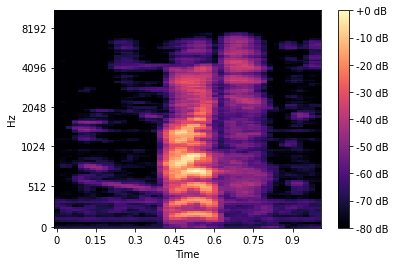

In [5]:
librosa.display.specshow(ac, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

In [6]:
extracted_feataures =[]
for root, directories, files in os.walk(os.path.join(root_path,"dataset1")):
    for file_names in files:
        if root is not root_path:
            #print(os.path.join(root,file_names))
            data = get_spectrogram(os.path.join(root,file_names))
            extracted_feataures.append([data,os.path.basename(os.path.normpath(root))])

C:\Users\sarib\AppData\Local\Temp\ipykernel_19316\3768912960.py:4: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram = librosa.feature.melspectrogram(signal)
C:\Users\sarib\AppData\Local\Temp\ipykernel_19316\3768912960.py:4: FutureWarning: Pass y=[-5.9660564e-05 -1.7664862e-04 -3.6537624e-04 ...  1.0201340e-04
  1.3263593e-04  5.8844234e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram = librosa.feature.melspectrogram(signal)
C:\Users\sarib\AppData\Local\Temp\ipykernel_19316\3768912960.py:4: FutureWarning: Pass y=[5.3346873e-04 6.3750986e-04 6.4097950e-04 ... 1.2940567e-04 9.3590417e-05
 3.9358496e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram = librosa.feature.melspectrogram(signal)
C:\Users\sarib\AppData\Local\Temp\ipykernel_19316\376891

In [7]:
extracted_feataures_dataframe= pd.DataFrame(extracted_feataures, columns=["melspectrogram", "word"])
extracted_feataures_dataframe.head()
extracted_feataures_dataframe.count()

melspectrogram    70
word              70
dtype: int64

In [8]:
extracted_feataures_dataframe['word'].value_counts()

ac        5
asagi     5
baslat    5
devam     5
dur       5
evet      5
geri      5
hayir     5
ileri     5
iptal     5
kapa      5
sag       5
sol       5
yukari    5
Name: word, dtype: int64

In [9]:
X=np.array(extracted_feataures_dataframe['melspectrogram'].tolist())
Y=np.array(extracted_feataures_dataframe['word'].tolist())

In [10]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
Y_numerical=to_categorical(labelencoder.fit_transform(Y))

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test= train_test_split(X,Y_numerical, test_size=0.2, random_state=0)

In [12]:
INPUT_SHAPE=(128,44,1)

In [13]:
X_test.shape

(14, 128, 44)

TRANSFER LEARNING

In [14]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,CSVLogger
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [15]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128,44,1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(128,44,1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(128,44,1)))


model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(Y_numerical.shape[1],activation='softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 42, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 21, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 19, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 9, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 7, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 12544)             0

In [17]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=Adam(learning_rate=0.001))

In [18]:
checkpointpath="checkpoint/cp.ckpt"
checkpointer = ModelCheckpoint(checkpointpath, monitor='val_accuracy',
                               verbose=2, save_best_only=True, mode='max')

history=model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test), callbacks=[checkpointer], verbose=2)

Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.07143, saving model to checkpoint\cp.ckpt
INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets
2/2 - 2s - loss: 22.4530 - accuracy: 0.0536 - val_loss: 21.3565 - val_accuracy: 0.0714 - 2s/epoch - 1s/step
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.07143
2/2 - 0s - loss: 15.4855 - accuracy: 0.1429 - val_loss: 5.4774 - val_accuracy: 0.0714 - 364ms/epoch - 182ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.07143 to 0.21429, saving model to checkpoint\cp.ckpt
INFO:tensorflow:Assets written to: checkpoint\cp.ckpt\assets
2/2 - 2s - loss: 4.0415 - accuracy: 0.0893 - val_loss: 2.7524 - val_accuracy: 0.2143 - 2s/epoch - 1s/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.21429
2/2 - 0s - loss: 2.7180 - accuracy: 0.1250 - val_loss: 3.1006 - val_accuracy: 0.0714 - 390ms/epoch - 195ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.21429
2/2 - 1s - loss: 2.5762 - accuracy: 0.1250 - va

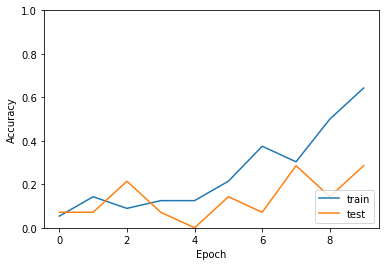

In [19]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [20]:
print("Test Score: ", model.evaluate(X_test,Y_test))
print("Train Score: ", model.evaluate(X_train,Y_train))

1/1 [==============================] - 0s 46ms/step - loss: 2.5585 - accuracy: 0.2857
Test Score:  [2.5585055351257324, 0.2857142984867096]
2/2 [==============================] - 0s 38ms/step - loss: 1.1339 - accuracy: 0.7321
Train Score:  [1.1338601112365723, 0.7321428656578064]


In [21]:
model.load_weights(checkpointpath)

In [22]:
print("Test Score: ", model.evaluate(X_test,Y_test))
print("Train Score: ", model.evaluate(X_train,Y_train))

1/1 [==============================] - 0s 48ms/step - loss: 2.4747 - accuracy: 0.2857
Test Score:  [2.4747440814971924, 0.2857142984867096]
2/2 [==============================] - 0s 32ms/step - loss: 1.6966 - accuracy: 0.5893
Train Score:  [1.6966279745101929, 0.5892857313156128]


In [23]:
predictiondata_feataures_initial =[]
counter_true_initial=0
for root, directories, files in os.walk("C:/Users/sarib/Desktop/Gohm/SpeechRecognition/RecordsFromDataset"): 
    for file_names in files:
        if root is not root_path:
            #print(os.path.join(root,file_names) )
            r = get_spectrogram(os.path.join(root,file_names))
            #rl=r.reshape(1,-1)
            rl = r[np.newaxis, ...]
            predicted_label_initial=np.argmax(model.predict(rl), axis=1)
            prediction_class_initial = labelencoder.inverse_transform(predicted_label_initial) 
            predictiondata_feataures_initial.append([os.path.basename(os.path.normpath(root)), prediction_class_initial, predicted_label_initial])
            if os.path.basename(os.path.normpath(root))==prediction_class_initial:
                counter_true_initial+=1

C:\Users\sarib\AppData\Local\Temp\ipykernel_19316\3768912960.py:4: FutureWarning: Pass y=[ 1.2192075e-04  2.2335145e-04  2.5522904e-04 ...  1.8752960e-05
 -1.5620921e-05  4.6200835e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram = librosa.feature.melspectrogram(signal)
C:\Users\sarib\AppData\Local\Temp\ipykernel_19316\3768912960.py:4: FutureWarning: Pass y=[ 0.00041042  0.00018144 -0.00019751 ...  0.00013579 -0.00047579
 -0.00049674] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram = librosa.feature.melspectrogram(signal)
C:\Users\sarib\AppData\Local\Temp\ipykernel_19316\3768912960.py:4: FutureWarning: Pass y=[6.5817434e-04 9.3733420e-04 9.5855736e-04 ... 2.3620379e-04 2.2297850e-04
 9.9829907e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram = librosa.feature.melspectrogram(signal)
C

In [24]:
predictiondata_feataures_dataframe_initial= pd.DataFrame(predictiondata_feataures_initial, columns=["actual data", "predicted data", "predicted data code"])
percentage_initial= (counter_true_initial/len(predictiondata_feataures_initial))*100
print("The percantage of the true predicted data: ", percentage_initial,"%")
#predictiondata_feataures_dataframe.to_csv("output.csv")
predictiondata_feataures_dataframe_initial

The percantage of the true predicted data:  38.095238095238095 %


,actual data,predicted data,predicted data code
0,ac,[ac],[0]
1,ac,[ac],[0]
2,ac,[sag],[11]
3,asagi,[asagi],[1]
4,asagi,[ileri],[8]
5,asagi,[asagi],[1]
6,baslat,[baslat],[2]
7,baslat,[baslat],[2]
8,baslat,[baslat],[2]
9,devam,[sag],[11]


ADDING SECOND DATASET

In [25]:
extracted_feataures2 =[]
for root, directories, files in os.walk(os.path.join(root_path,"dataset2")):
    for file_names in files:
        if root is not root_path:
            #print(os.path.join(root,file_names))
            data = get_spectrogram(os.path.join(root,file_names))
            extracted_feataures2.append([data,os.path.basename(os.path.normpath(root))])

C:\Users\sarib\AppData\Local\Temp\ipykernel_19316\3768912960.py:4: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram = librosa.feature.melspectrogram(signal)
C:\Users\sarib\AppData\Local\Temp\ipykernel_19316\3768912960.py:4: FutureWarning: Pass y=[ 8.9784060e-04  1.2294345e-03  9.7495673e-04 ... -1.3378418e-04
 -6.0058883e-05 -8.6978675e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram = librosa.feature.melspectrogram(signal)
C:\Users\sarib\AppData\Local\Temp\ipykernel_19316\3768912960.py:4: FutureWarning: Pass y=[-0.00012486 -0.00048789 -0.00067051 ...  0.00040196  0.00030053
  0.00017929] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram = librosa.feature.melspectrogram(signal)
C:\Users\sarib\AppData\Local\Temp\ipykernel_19316\3768912960.py:4: F

In [26]:
extracted_feataures_dataframe2= pd.DataFrame(extracted_feataures2, columns=["melspectrogram", "word"])
extracted_feataures_dataframe2.head()
extracted_feataures_dataframe2.count()

melspectrogram    71
word              71
dtype: int64

In [27]:
extracted_feataures_dataframe2['word'].value_counts()

ac        6
asagi     5
baslat    5
devam     5
dur       5
evet      5
geri      5
hayir     5
ileri     5
iptal     5
kapa      5
sag       5
sol       5
yukari    5
Name: word, dtype: int64

In [28]:
X2=np.array(extracted_feataures_dataframe2['melspectrogram'].tolist())
Y2=np.array(extracted_feataures_dataframe2['word'].tolist())

In [29]:
labelencoder2=LabelEncoder()
Y_numerical2=to_categorical(labelencoder.fit_transform(Y2))

In [30]:
X_train2, X_test2, Y_train2, Y_test2= train_test_split(X2,Y_numerical2, test_size=0.2, random_state=0)

In [31]:
history2=model.fit(X_train2, Y_train2, epochs=10, validation_data=(X_test2, Y_test2), verbose=2)

Epoch 1/10
2/2 - 0s - loss: 2.1305 - accuracy: 0.3750 - val_loss: 2.5116 - val_accuracy: 0.2000 - 368ms/epoch - 184ms/step
Epoch 2/10
2/2 - 0s - loss: 1.8908 - accuracy: 0.4643 - val_loss: 2.5432 - val_accuracy: 0.2667 - 345ms/epoch - 173ms/step
Epoch 3/10
2/2 - 0s - loss: 1.6275 - accuracy: 0.5536 - val_loss: 3.3463 - val_accuracy: 0.2000 - 351ms/epoch - 176ms/step
Epoch 4/10
2/2 - 0s - loss: 1.4650 - accuracy: 0.5893 - val_loss: 2.9442 - val_accuracy: 0.2667 - 290ms/epoch - 145ms/step
Epoch 5/10
2/2 - 0s - loss: 1.3114 - accuracy: 0.5714 - val_loss: 2.6709 - val_accuracy: 0.2000 - 300ms/epoch - 150ms/step
Epoch 6/10
2/2 - 0s - loss: 0.9446 - accuracy: 0.7321 - val_loss: 2.8156 - val_accuracy: 0.4000 - 301ms/epoch - 150ms/step
Epoch 7/10
2/2 - 0s - loss: 0.7691 - accuracy: 0.8393 - val_loss: 3.1656 - val_accuracy: 0.3333 - 287ms/epoch - 143ms/step
Epoch 8/10
2/2 - 0s - loss: 0.5591 - accuracy: 0.8571 - val_loss: 2.5999 - val_accuracy: 0.2667 - 302ms/epoch - 151ms/step
Epoch 9/10
2/2 -

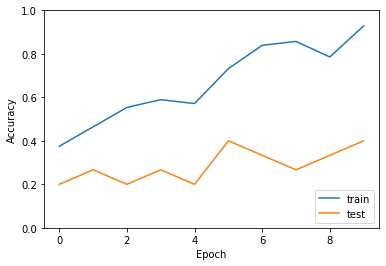

In [32]:
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [33]:
print("Test Score: ", model.evaluate(X_test2,Y_test2))
print("Train Score: ", model.evaluate(X_train2,Y_train2))

1/1 [==============================] - 0s 49ms/step - loss: 2.6478 - accuracy: 0.4000
Test Score:  [2.6478476524353027, 0.4000000059604645]
2/2 [==============================] - 0s 32ms/step - loss: 0.3184 - accuracy: 0.9464
Train Score:  [0.31844207644462585, 0.9464285969734192]


In [34]:
print("Test Score: ", model.evaluate(X_test,Y_test))
print("Train Score: ", model.evaluate(X_train,Y_train))

1/1 [==============================] - 0s 41ms/step - loss: 2.1573 - accuracy: 0.3571
Test Score:  [2.1572821140289307, 0.3571428656578064]
2/2 [==============================] - 0s 48ms/step - loss: 0.9254 - accuracy: 0.7857
Train Score:  [0.9254066348075867, 0.7857142686843872]


**PREDICTION WITH DATA**

In [35]:
predictiondata_feataures =[]
counter_true=0
for root, directories, files in os.walk("C:/Users/sarib/Desktop/Gohm/SpeechRecognition/RecordsFromDataset"): 
    for file_names in files:
        if root is not root_path:
            #print(os.path.join(root,file_names) )
            r = get_spectrogram(os.path.join(root,file_names))
            #rl=r.reshape(1,-1)
            rl = r[np.newaxis, ...]
            predicted_label=np.argmax(model.predict(rl), axis=1)
            prediction_class = labelencoder.inverse_transform(predicted_label) 
            predictiondata_feataures.append([os.path.basename(os.path.normpath(root)), prediction_class, predicted_label])
            if os.path.basename(os.path.normpath(root))==prediction_class:
                counter_true+=1

C:\Users\sarib\AppData\Local\Temp\ipykernel_19316\3768912960.py:4: FutureWarning: Pass y=[ 1.2192075e-04  2.2335145e-04  2.5522904e-04 ...  1.8752960e-05
 -1.5620921e-05  4.6200835e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram = librosa.feature.melspectrogram(signal)
C:\Users\sarib\AppData\Local\Temp\ipykernel_19316\3768912960.py:4: FutureWarning: Pass y=[ 0.00041042  0.00018144 -0.00019751 ...  0.00013579 -0.00047579
 -0.00049674] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram = librosa.feature.melspectrogram(signal)
C:\Users\sarib\AppData\Local\Temp\ipykernel_19316\3768912960.py:4: FutureWarning: Pass y=[6.5817434e-04 9.3733420e-04 9.5855736e-04 ... 2.3620379e-04 2.2297850e-04
 9.9829907e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspectrogram = librosa.feature.melspectrogram(signal)
C

In [36]:
predictiondata_feataures_dataframe= pd.DataFrame(predictiondata_feataures, columns=["actual data", "predicted data", "predicted data code"])
percentage= (counter_true/len(predictiondata_feataures))*100
print("The percantage of the true predicted data: ", percentage,"%")
#predictiondata_feataures_dataframe.to_csv("output.csv")
predictiondata_feataures_dataframe

The percantage of the true predicted data:  61.904761904761905 %


,actual data,predicted data,predicted data code
0,ac,[ac],[0]
1,ac,[ac],[0]
2,ac,[ac],[0]
3,asagi,[asagi],[1]
4,asagi,[asagi],[1]
5,asagi,[asagi],[1]
6,baslat,[baslat],[2]
7,baslat,[baslat],[2]
8,baslat,[baslat],[2]
9,devam,[devam],[3]
